In [1]:
from sklearnex import patch_sklearn
patch_sklearn(global_patch=True)
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics, tree
from shap import TreeExplainer
import fasttreeshap
from shap import plots, Explanation
import graphviz 
from yellowbrick.model_selection import LearningCurve
import time
import shap
from utils import *
import pickle

pd.set_option('display.max_columns', None)

Scikit-learn was successfully globally patched by Intel(R) Extension for Scikit-learn


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
# you should run making_hikari2022_csv.ipynb before running this cell, since the two csv given with the paper have two differences
# to see what are the data types and the features of the dataset, you can take a look on the utils file
ds = pd.concat([
    pd.read_csv('datasets/HIKARI-2021/ALLFLOWMETER_HIKARI2021.csv', dtype=dtype_dict, usecols=selected_features),
    pd.read_csv('datasets/HIKARI-2021/ALLFLOWMETER_HIKARI2022.csv', dtype=dtype_dict, usecols=selected_features)], 
    ignore_index=True)
ds.head()

,flow_duration,fwd_pkts_tot,bwd_pkts_tot,fwd_data_pkts_tot,bwd_data_pkts_tot,fwd_pkts_per_sec,bwd_pkts_per_sec,flow_pkts_per_sec,down_up_ratio,fwd_header_size_tot,fwd_header_size_min,fwd_header_size_max,bwd_header_size_tot,bwd_header_size_min,bwd_header_size_max,flow_FIN_flag_count,flow_SYN_flag_count,flow_RST_flag_count,fwd_PSH_flag_count,bwd_PSH_flag_count,flow_ACK_flag_count,fwd_URG_flag_count,bwd_URG_flag_count,flow_CWR_flag_count,flow_ECE_flag_count,fwd_pkts_payload.min,fwd_pkts_payload.max,fwd_pkts_payload.tot,fwd_pkts_payload.avg,fwd_pkts_payload.std,bwd_pkts_payload.min,bwd_pkts_payload.max,bwd_pkts_payload.tot,bwd_pkts_payload.avg,bwd_pkts_payload.std,flow_pkts_payload.min,flow_pkts_payload.max,flow_pkts_payload.tot,flow_pkts_payload.avg,flow_pkts_payload.std,fwd_iat.min,fwd_iat.max,fwd_iat.tot,fwd_iat.avg,fwd_iat.std,bwd_iat.min,bwd_iat.max,bwd_iat.tot,bwd_iat.avg,bwd_iat.std,flow_iat.min,flow_iat.max,flow_iat.tot,flow_iat.avg,flow_iat.std,payload_bytes_per_second,fwd_subflow_pkts,bwd_subflow_pkts,fwd_subflow_bytes,bwd_subflow_bytes,fwd_bulk_bytes,bwd_bulk_bytes,fwd_bulk_packets,bwd_bulk_packets,fwd_bulk_rate,bwd_bulk_rate,active.min,active.max,active.tot,active.avg,active.std,idle.min,idle.max,idle.tot,idle.avg,idle.std,fwd_init_window_size,bwd_init_window_size,fwd_last_window_size,traffic_category,Label
0,2.207588,15,14,6,6,6.794746,6.341763,13.136509,0.933333,464,20,40,492,32,44,2,2,2,6,5,26,0,0,0,0,0,742,1826.0,121.733333,220.736581,0,1448,5025.0,358.928571,552.239840,0,1448,6851.0,236.241379,424.859275,18.119812,1.963762e+06,2.207603e+06,1.576859e+05,5.205052e+05,7.867813,2.032929e+06,2.177950e+06,1.675346e+05,5.606267e+05,7.867813,1.963762e+06,2.207603e+06,78842.963491,3.696378e+05,3103.387105,7.5,7.0,913.0,2512.5,0.0,0.0,0.0,0.0,0.0,0.0,2.207603e+06,2.207603e+06,2.207603e+06,2.207603e+06,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,29200,65160,0,Bruteforce-XML,True
1,15.624266,15,14,6,6,0.960045,0.896042,1.856087,0.933333,488,20,44,468,32,44,2,2,2,6,5,26,0,0,0,0,0,745,1829.0,121.933333,221.339257,0,1448,5025.0,358.928571,552.239840,0,1448,6854.0,236.344828,424.987166,20.980835,1.534300e+07,1.562428e+07,1.116020e+06,4.094889e+06,20.980835,1.541144e+07,1.559517e+07,1.199628e+06,4.270148e+06,10.013580,1.534300e+07,1.562428e+07,558009.896960,2.897622e+06,438.676603,7.5,7.0,914.5,2512.5,0.0,0.0,0.0,0.0,0.0,0.0,2.883792e+04,2.524381e+05,2.812760e+05,1.406380e+05,158109.181742,1.534300e+07,1.534300e+07,1.534300e+07,1.534300e+07,0.0,29200,65160,0,Bruteforce-XML,True
2,12.203357,14,13,6,5,1.147225,1.065281,2.212506,0.928571,432,20,40,448,32,44,2,2,2,6,5,24,0,0,0,0,0,744,1828.0,130.571429,226.803444,0,2896,5025.0,386.538462,817.479013,0,2896,6853.0,253.814815,592.570284,36.001205,1.196814e+07,1.220338e+07,9.387216e+05,3.314032e+06,15.020370,1.203674e+07,1.217482e+07,1.014569e+06,3.471107e+06,15.020370,1.196814e+07,1.220338e+07,469360.810060,2.345336e+06,561.566789,7.0,6.5,914.0,2512.5,0.0,0.0,0.0,0.0,0.0,0.0,2.891302e+04,2.063251e+05,2.352381e+05,1.176190e+05,125449.251656,1.196814e+07,1.196814e+07,1.196814e+07,1.196814e+07,0.0,29200,65160,0,Bruteforce-XML,True
3,9.992448,14,13,6,5,1.401058,1.300983,2.702041,0.928571,432,20,40,436,32,44,2,2,2,6,5,24,0,0,0,0,0,744,1828.0,130.571429,226.803444,0,2896,5025.0,386.538462,817.479013,0,2896,6853.0,253.814815,592.570284,50.067902,9.759205e+06,9.992470e+06,7.686515e+05,2.701448e+06,20.980835,9.828447e+06,9.963348e+06,8.302790e+05,2.833716e+06,20.980835,9.759205e+06,9.992470e+06,384325.770231,1.912152e+06,685.817940,7.0,6.5,914.0,2512.5,0.0,0.0,0.0,0.0,0.0,0.0,2.952909e+04,2.037361e+05,2.332652e+05,1.166326e+05,123182.931318,9.759205e+06,9.759205e+06,9.759205e+06,9.759205e+06,0.0,29200,65160,0,Bruteforce-XML,True
4,7.780611,14,14,6,5,1.799345,1.799345,3.598689,1.000000,432,20,40,480,32,44,2,2,2,6,5,25,0,0,0,0,0,744,1828.0,130.571429,226.803444,0,2896,5025.0,358.928571,792.173394,0,2896,6853.0,244.750000,583.468215,16.927719,7.545305e+06,7.780620e+06,5.985092e+

In [3]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 783531 entries, 0 to 783530
Data columns (total 81 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   flow_duration             783531 non-null  float64
 1   fwd_pkts_tot              783531 non-null  uint64 
 2   bwd_pkts_tot              783531 non-null  uint64 
 3   fwd_data_pkts_tot         783531 non-null  uint64 
 4   bwd_data_pkts_tot         783531 non-null  uint64 
 5   fwd_pkts_per_sec          783531 non-null  float64
 6   bwd_pkts_per_sec          783531 non-null  float64
 7   flow_pkts_per_sec         783531 non-null  float64
 8   down_up_ratio             783531 non-null  float32
 9   fwd_header_size_tot       783531 non-null  uint64 
 10  fwd_header_size_min       783531 non-null  uint8  
 11  fwd_header_size_max       783531 non-null  uint8  
 12  bwd_header_size_tot       783531 non-null  uint64 
 13  bwd_header_size_min       783531 non-null  u

In [4]:
ds.describe()

,flow_duration,fwd_pkts_tot,bwd_pkts_tot,fwd_data_pkts_tot,bwd_data_pkts_tot,fwd_pkts_per_sec,bwd_pkts_per_sec,flow_pkts_per_sec,down_up_ratio,fwd_header_size_tot,fwd_header_size_min,fwd_header_size_max,bwd_header_size_tot,bwd_header_size_min,bwd_header_size_max,flow_FIN_flag_count,flow_SYN_flag_count,flow_RST_flag_count,fwd_PSH_flag_count,bwd_PSH_flag_count,flow_ACK_flag_count,fwd_URG_flag_count,bwd_URG_flag_count,flow_CWR_flag_count,flow_ECE_flag_count,fwd_pkts_payload.min,fwd_pkts_payload.max,fwd_pkts_payload.tot,fwd_pkts_payload.avg,fwd_pkts_payload.std,bwd_pkts_payload.min,bwd_pkts_payload.max,bwd_pkts_payload.tot,bwd_pkts_payload.avg,bwd_pkts_payload.std,flow_pkts_payload.min,flow_pkts_payload.max,flow_pkts_payload.tot,flow_pkts_payload.avg,flow_pkts_payload.std,fwd_iat.min,fwd_iat.max,fwd_iat.tot,fwd_iat.avg,fwd_iat.std,bwd_iat.min,bwd_iat.max,bwd_iat.tot,bwd_iat.avg,bwd_iat.std,flow_iat.min,flow_iat.max,flow_iat.tot,flow_iat.avg,flow_iat.std,payload_bytes_per_second,fwd_subflow_pkts,bwd_subflow_pkts,fwd_subflow_bytes,bwd_subflow_bytes,fwd_bulk_bytes,bwd_bulk_bytes,fwd_bulk_packets,bwd_bulk_packets,fwd_bulk_rate,bwd_bulk_rate,active.min,active.max,active.tot,active.avg,active.std,idle.min,idle.max,idle.tot,idle.avg,idle.std,fwd_init_window_size,bwd_init_window_size,fwd_last_window_size
count,783531.000000,783531.000000,783531.000000,783531.000000,783531.000000,7.835310e+05,7.835310e+05,7.835310e+05,783531.000000,7.835310e+05,783531.000000,783531.000000,7.835310e+05,783531.000000,783531.000000,783531.000000,783531.000000,783531.000000,783531.000000,783531.000000,783531.000000,783531.000000,783531.000000,783531.000000,783531.000000,783531.000000,783531.000000,7.835310e+05,7.835310e+05,783531.000000,783531.000000,783531.000000,7.835310e+05,7.835310e+05,7.835310e+05,783531.000000,783531.000000,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,783531.000000,783531.000000,783531.000000,7.835310e+05,7.835310e+05,7.835310e+05,783531.000000,783531.000000,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,783531.000000,783531.000000,783531.000000
mean,7.930232,15.141476,15.202140,6.076205,11.985713,3.475753e+03,2.813504e+03,6.284778e+03,1.975985,5.221322e+02,23.148409,28.325925,4.665602e+02,18.626142,22.381593,0.778524,1.156447,0.418391,5.386756,8.314095,28.377589,0.001020,0.000008,0.001668,0.000037,17.793925,193.943558,1.685628e+03,1.054549e+02,54.541936,22.216197,1167.560257,1.975559e+04,5.381859e+02,3.519654e+02,17.805741,1178.124581,2.144121e+04,4.416836e+02,2.990518e+02,8.931155e+05,5.733389e+06,8.904876e+06,1.332912e+06,1.162227e+06,2.537420e+04,4.618173e+06,6.764059e+06,4.246261e+05,1.293048e+06,8.930607e+05,6.085861e+06,1.011627e+07,1.260414e+06,8.197949e+05,8.433863e+04,10.925990,11.081897,1159.948376,1.210176e+04,9.029155e+01,4.742144e+03,0.043071,1.864668,6.219484e+03,4.148455e+06,8.041311e+05,1.059131e+06,1.148116e+06,8.946945e+05,1.179072e+05,4.571039e+06,5.764442e+06,8.678673e+06,5.109868e+06,6.037600e+05,25885.029520,26880.533083,7417.383553
std,97.220072,390.717612,395.026085,62.401492,393.515497,1.696581e+05,1.579508e+05,3.246767e+05,31.937681,1.484319e+04,12.629693,15.981276,1.259048e+04,12.781371,16.568396,0.999198,1.029890,0.812277,62.129340,145.891623,785.296047,0.032707,0.002767,0.048602,0.006490,32.828224,300.906381,6.378143e+04,3.639657e+03,351.378688,43.025812,2464.742493,3.385688e+05,1.639081e+04,2.860092e+03,32.883272,2464.226347,3.469619e+05,1.280389e+04,4.456432e+03,6.836720e+07,2.356495e+08,2.966493e+08,9.935204e+07,6.019453e+07,1.451423e+06,2.256559e+08,1.885185e+08,2.769771e+07,1.059583e+08,6.836746e+07,3.022425e+08,7.036060e+08,1.011819e+08,3.227715e+07,5.690312e+06,73.305702,80.394173,14522.031819,1.

In [5]:
ds.columns

Index(['flow_duration', 'fwd_pkts_tot', 'bwd_pkts_tot', 'fwd_data_pkts_tot',
       'bwd_data_pkts_tot', 'fwd_pkts_per_sec', 'bwd_pkts_per_sec',
       'flow_pkts_per_sec', 'down_up_ratio', 'fwd_header_size_tot',
       'fwd_header_size_min', 'fwd_header_size_max', 'bwd_header_size_tot',
       'bwd_header_size_min', 'bwd_header_size_max', 'flow_FIN_flag_count',
       'flow_SYN_flag_count', 'flow_RST_flag_count', 'fwd_PSH_flag_count',
       'bwd_PSH_flag_count', 'flow_ACK_flag_count', 'fwd_URG_flag_count',
       'bwd_URG_flag_count', 'flow_CWR_flag_count', 'flow_ECE_flag_count',
       'fwd_pkts_payload.min', 'fwd_pkts_payload.max', 'fwd_pkts_payload.tot',
       'fwd_pkts_payload.avg', 'fwd_pkts_payload.std', 'bwd_pkts_payload.min',
       'bwd_pkts_payload.max', 'bwd_pkts_payload.tot', 'bwd_pkts_payload.avg',
       'bwd_pkts_payload.std', 'flow_pkts_payload.min',
       'flow_pkts_payload.max', 'flow_pkts_payload.tot',
       'flow_pkts_payload.avg', 'flow_pkts_payload.std', 'fwd

We can see from this graph that we don't have highly correlated features.

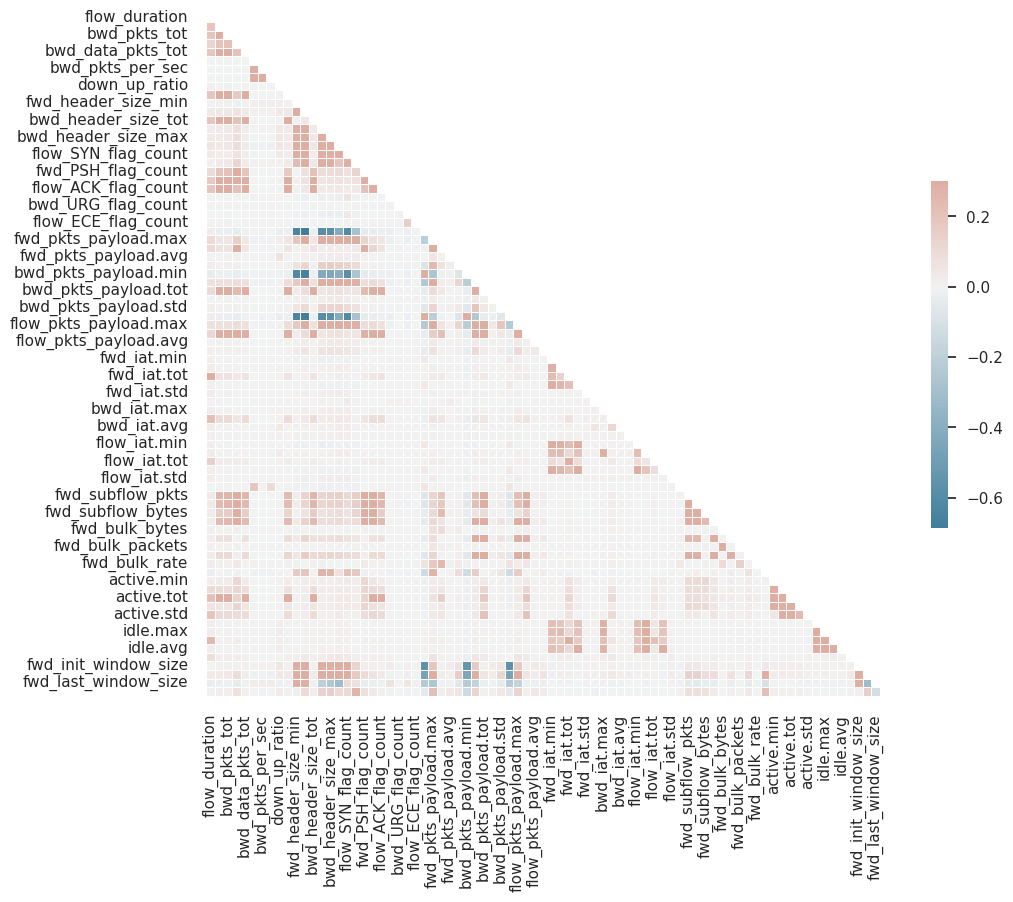

In [6]:
show_corr_matrix(ds)

In [7]:
compute_ratio(ds)

                     Ratio
traffic_category          
Benign               71.77
Background           21.72
Probing               2.98
XMRIGCC CryptoMiner   1.39
Bruteforce-XML        1.12
Bruteforce            1.02


In [27]:
params = {
    "n_jobs": -1, 
    "n_estimators": 5,
    "max_depth": 14,
    "random_state": 42,
    "max_features": len(x_features)
}

In [28]:
rf = RandomForestClassifier(**params)
pv = DataPreprocessingAndValidation(ds, 7988, 5, RandomForestClassifier, params)

In [29]:
X_res, y_res = pv.get_undersampled_ds()
X_train, X_test, y_train, y_test = train_test_split(X_res, ds.loc[y_res.index].Label, test_size = 0.2, random_state=12,  stratify=y_res)

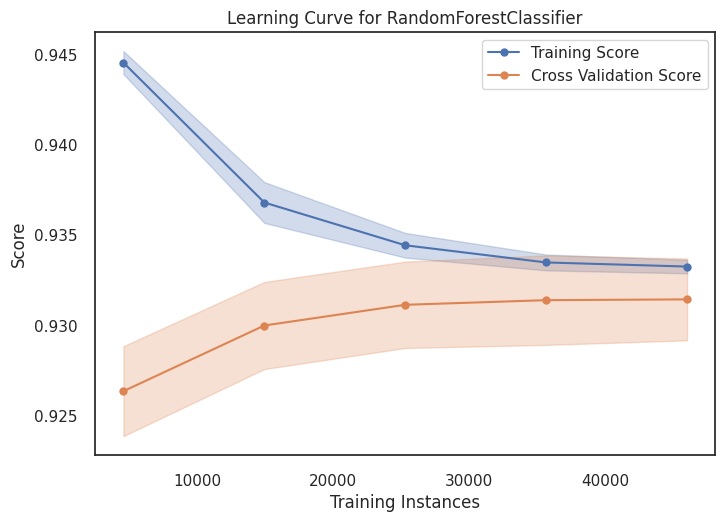

In [21]:
if True:
    cv = 10
    visualizer = LearningCurve(estimator=rf, cv=cv, scoring='f1', n_jobs=1, random_state=123)
    visualizer.fit(X_train, y_train)
    visualizer.show(outpath="rf_data/learning_curve.png")


![Alt text](rf_data/learning_curve.png)

In [30]:
%time pv.cross_validation(ds[x_features], ds.Label, y_res)

Running the stratified 5-fold
Test and Train k-fold created
Running the cross validation
CPU times: user 60 s, sys: 225 ms, total: 1min
Wall time: 50.9 s


(0.9309666793327193, 0.0014033719375181337, 4.455583810806274)

In [13]:
%time rf.fit(X_train, y_train)

CPU times: user 1.37 s, sys: 4.17 ms, total: 1.37 s
Wall time: 498 ms


RandomForestClassifier(max_depth=6, max_features=79, n_estimators=3, n_jobs=-1,
                       random_state=42)

In [14]:
%time y_predicted_train = rf.predict(X_train)
%time y_predicted_test = rf.predict(X_test)

CPU times: user 21.8 ms, sys: 0 ns, total: 21.8 ms
Wall time: 22.1 ms
CPU times: user 9.83 ms, sys: 0 ns, total: 9.83 ms
Wall time: 17.2 ms


In [15]:
performanceMetricsDF(metrics, y_train, y_predicted_train, y_test, y_predicted_test)

,Measure,Train,Test
0,ACCURACY,0.991471,0.991707
1,PRECISION,0.984496,0.986985
2,RECALL,0.998670,0.996558
3,F1 SCORE,0.991532,0.991748
4,AUC,0.991472,0.991706


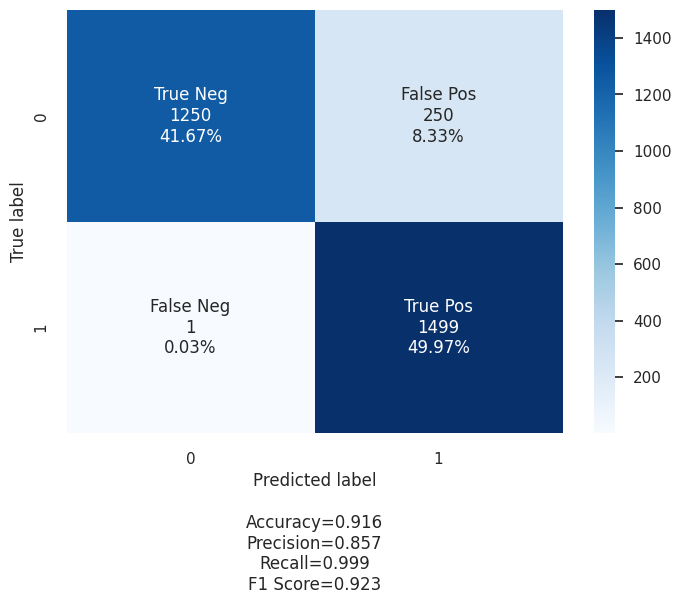

In [152]:
# Show the confusion matrix
cf = metrics.confusion_matrix(y_test,y_predicted_test)
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['0', '1']
make_confusion_matrix(cf, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues')

In [112]:
for num, clf in enumerate(rf.estimators_):
    print(clf.get_depth())

6
6
6


In [113]:
for num, clf in enumerate(rf.estimators_):
    dot_data = tree.export_graphviz(clf, feature_names=x_features, out_file=None, ) 
    graph = graphviz.Source(dot_data)
    graph.render('tree/tree_rf_' + str(num))

In [114]:
start_time = time.time()
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.018 seconds


Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


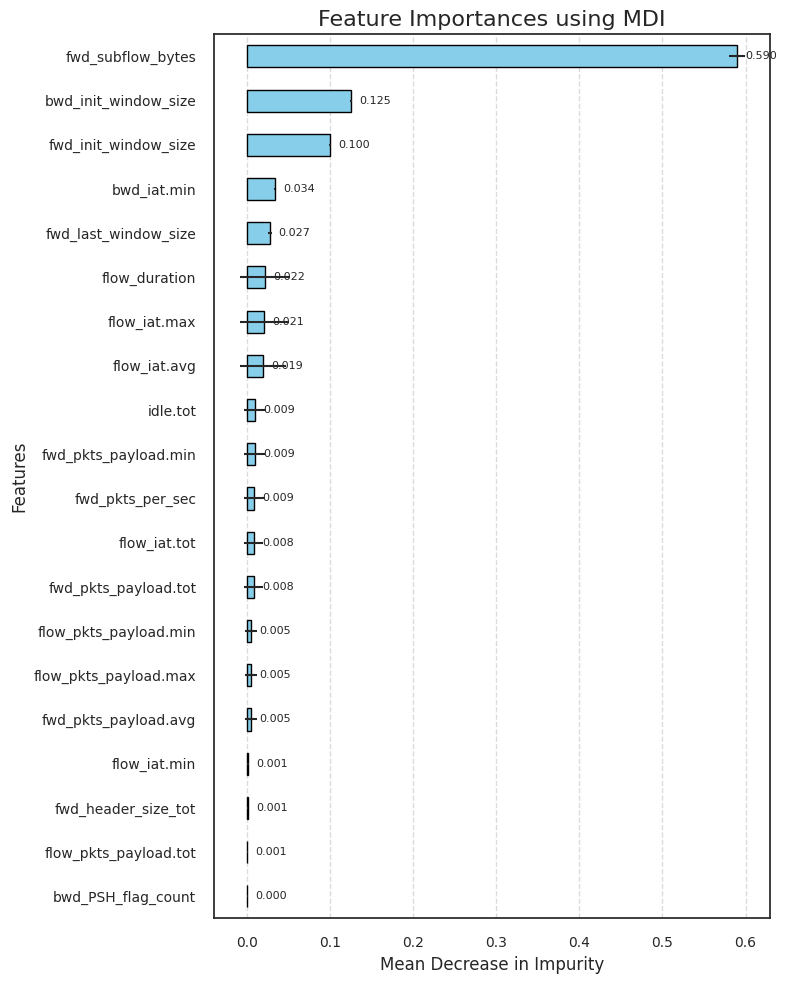

In [115]:
forest_importances = pd.Series(importances, index=x_features)

sorted_indices = np.argsort(forest_importances)[::-1]
sorted_std = std[sorted_indices][:20] # Select only the first 20 features
sorted_importance = forest_importances[sorted_indices][:20]  # Select importance values for the first 20 features

# Create the figure and axis
fig, ax = plt.subplots(figsize=(8, 10))  # Adjust the figure size as needed for vertical display

# Create the vertical bar plot with error bars
sorted_importance.plot(kind='barh', xerr=sorted_std, ax=ax, color='skyblue', edgecolor='black')

# Set plot title and labels
ax.set_title("Feature Importances using MDI", fontsize=16)
ax.set_xlabel("Mean Decrease in Impurity", fontsize=12)
ax.set_ylabel("Features", fontsize=12)

# Customize ticks and grid
ax.tick_params(axis='both', which='major', labelsize=10)
ax.grid(axis='x', linestyle='--', alpha=0.7)

# Invert y-axis to display most important feature at the top
ax.invert_yaxis()

# Add data labels at the end of each bar
for i, v in enumerate(sorted_importance):
    ax.text(v + 0.01, i, f'{v:.3f}', va='center', fontsize=8)

# Show the plot
plt.tight_layout()
plt.show()

Using interventional to stay "true to the model" since we will use this data to do feature reduction and we want also to understand how things work

In [116]:
%%time

explainer = fasttreeshap.TreeExplainer(rf, X_train, algorithm='auto', n_jobs=-1, feature_perturbation="interventional") 
sv = explainer(X_train)

exp = Explanation(sv.values[:,:,1], 
                  sv.base_values[:,1], 
                  data=X_train, 
                  feature_names=x_features)

CPU times: user 7.2 s, sys: 88.1 ms, total: 7.28 s
Wall time: 7.25 s


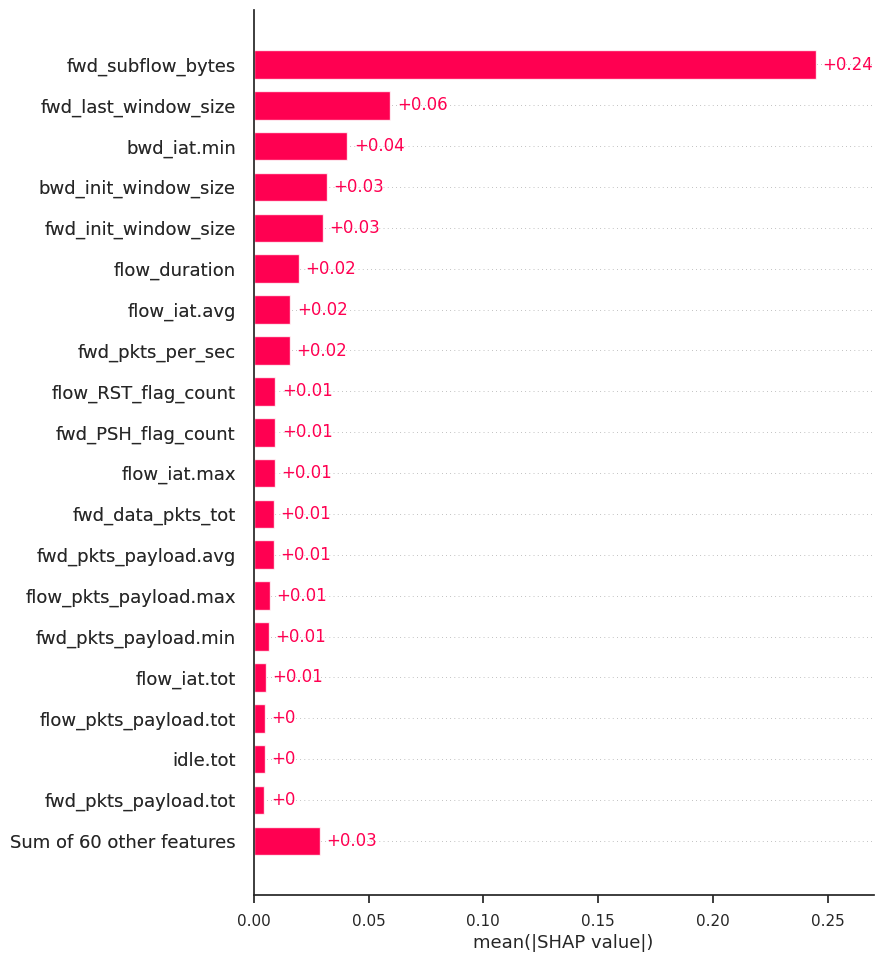

In [117]:
plots.bar(exp, max_display=20, show=False)
# plt.savefig('tree/shap', dpi=1400, format='pdf', pad_inches=10)
plt.show()

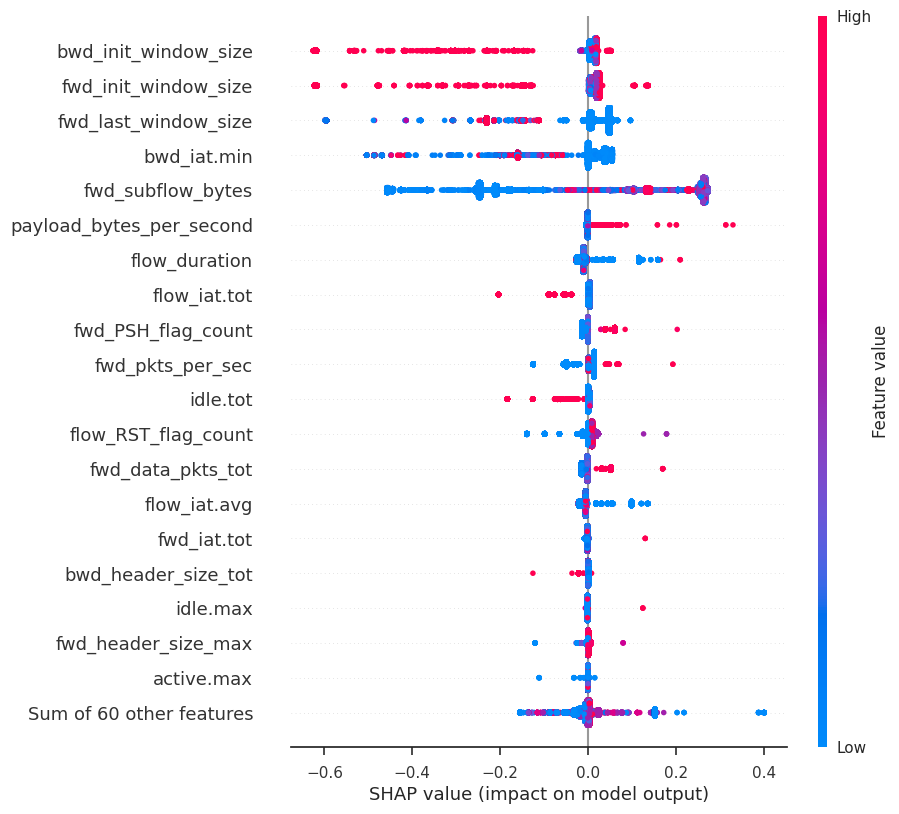

In [118]:
plots.beeswarm(exp,order=exp.abs.max(0),max_display=20)

In [119]:
pv.feature_importance = pd.DataFrame(data={'importance' : exp.abs.mean(0).values, 'feature': x_features})
pv.feature_importance.sort_values('importance',ascending=False).head(20)

,importance,feature
58,0.244854,fwd_subflow_bytes
78,0.059472,fwd_last_window_size
45,0.040788,bwd_iat.min
77,0.031720,bwd_init_window_size
76,0.030026,fwd_init_window_size
0,0.019773,flow_duration
53,0.015941,flow_iat.avg
5,0.015597,fwd_pkts_per_sec
17,0.009407,flow_RST_flag_count
18,0.009356,fwd_PSH_flag_count


In [120]:
pv.feature_above_zero = pv.feature_importance.query('importance > 0').sort_values('importance',ascending=False)['feature'].to_list()

In [121]:
%%time

if True:
    result = pv.recursive_reduction()
    feature_reduction_scores = pd.DataFrame({'F1_score': result[0], 'score_std': result[1], 'n_features': result[2], 'cv_time': result[3]})
    
    with open('rf_data/feature_reduction_scores.pickle', 'wb') as handle:
        pickle.dump(feature_reduction_scores, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open('rf_data/feature_reduction_scores.pickle', 'rb') as handle:
        feature_reduction_scores = pickle.load(handle)

Running the cross validation
testing with 36 features
Running the cross validation
testing with 35 features
Running the cross validation
testing with 34 features
Running the cross validation
testing with 33 features
Running the cross validation
testing with 32 features
Running the cross validation
testing with 31 features
Running the cross validation
testing with 30 features
Running the cross validation
testing with 29 features
Running the cross validation
testing with 28 features
Running the cross validation
testing with 27 features
Running the cross validation
testing with 26 features
Running the cross validation
testing with 25 features
Running the cross validation
testing with 24 features
Running the cross validation
testing with 23 features
Running the cross validation
testing with 22 features
Running the cross validation
testing with 21 features
Running the cross validation
testing with 20 features
Running the cross validation
testing with 19 features
Running the cross validation

<Axes: xlabel='n_features', ylabel='cv_time'>

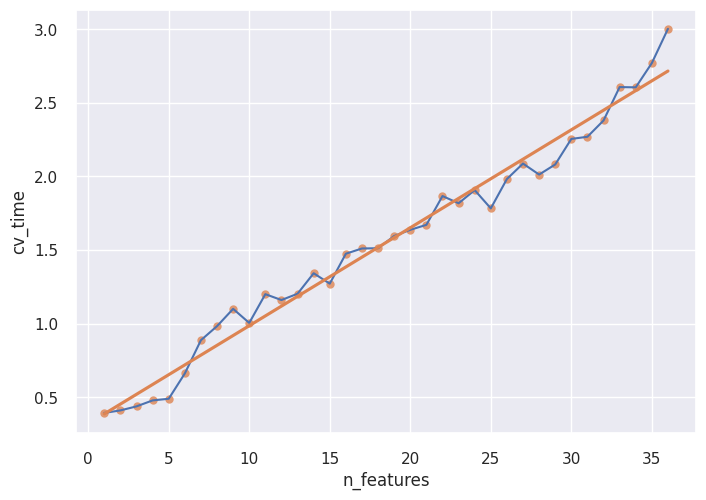

In [122]:
sns.set_theme()
sns.lineplot(data=feature_reduction_scores, x="n_features", y="cv_time")
sns.regplot(data=feature_reduction_scores, x="n_features", y="cv_time", ci=None)  # ci=None removes confidence intervals

<Axes: xlabel='n_features', ylabel='F1_score'>

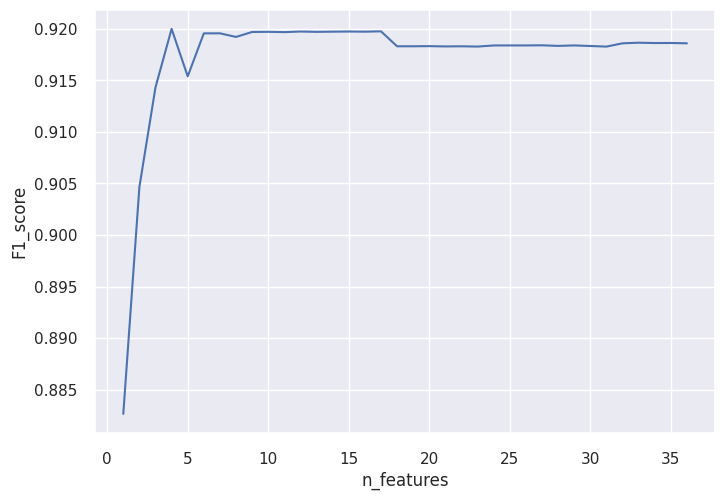

In [123]:
sns.set_theme()
sns.lineplot(data=feature_reduction_scores, x="n_features", y="F1_score")

<Axes: xlabel='n_features', ylabel='score_std'>

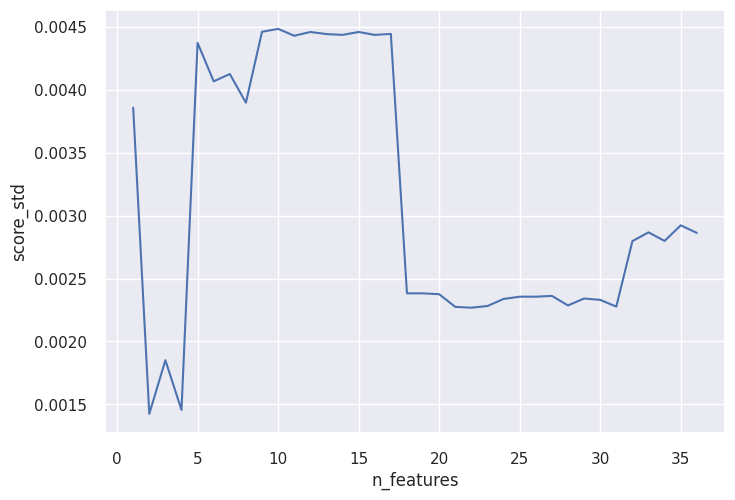

In [124]:
sns.set_theme()
sns.lineplot(data=feature_reduction_scores, x="n_features", y="score_std")

In [125]:
feature_reduction_scores.sort_values('F1_score', ascending=False)

,F1_score,score_std,n_features,cv_time
32,0.919998,0.001456,4,0.478061
19,0.919760,0.004444,17,1.510099
24,0.919740,0.004459,12,1.159892
21,0.919740,0.004459,15,1.271119
22,0.919726,0.004436,14,1.341874
20,0.919726,0.004436,16,1.474487
26,0.919711,0.004484,10,1.004283
23,0.919709,0.004443,13,1.202561
27,0.919698,0.004461,9,1.099947
25,0.919682,0.004430,11,1.199755


In [126]:
%%time

if True:
    zero_day_feature_reduction_scores = pv.run_zero_day_test()
    with open('rf_data/zero_day_feature_reduction_scores.pickle', 'wb') as handle:
        pickle.dump(zero_day_feature_reduction_scores, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open('rf_data/zero_day_feature_reduction_scores.pickle', 'rb') as handle:
        zero_day_feature_reduction_scores = pickle.load(handle)

traing for  XMRIGCC CryptoMiner
training with 36 features
Running the stratified 5-fold
Test and Train k-fold created
Running the cross validation
training with 35 features
Running the cross validation
training with 34 features
Running the cross validation
training with 33 features
Running the cross validation
training with 32 features
Running the cross validation
training with 31 features
Running the cross validation
training with 30 features
Running the cross validation
training with 29 features
Running the cross validation
training with 28 features
Running the cross validation
training with 27 features
Running the cross validation
training with 26 features
Running the cross validation
training with 25 features
Running the cross validation
training with 24 features
Running the cross validation
training with 23 features
Running the cross validation
training with 22 features
Running the cross validation
training with 21 features
Running the cross validation
training with 20 features
Ru

KeyboardInterrupt: 

Here we can have zero on the results of f1 and recall that means that the model has failed to detect the attack, while the cross validation result is usefull only to see how well the model is scoring with all the data except the one regarding the attack

In [38]:
# here I create this detected variable, so that we can see how many attacks are detected because only by using the mean we didn't get the best one
zero_day_feature_reduction_scores['detected'] = np.where(zero_day_feature_reduction_scores['attack_recall'] > 0, 1, 0)

In [39]:
zero_day_feature_reduction_scores.query('attack_recall != 0').sort_values('attack_recall', ascending=False)

,attack_f1,attack_recall,attack_precision,cv_score_avg,cv_score_std,n_features,attack_name,fit_time,pred_time,detected
79,0.868945,0.872522,0.865396,0.938322,0.042812,5,Bruteforce,0.027115,0.014117,1
78,0.868945,0.872522,0.865396,0.939470,0.041515,6,Bruteforce,0.027380,0.013539,1
77,0.726619,0.646844,0.828839,0.937985,0.042466,7,Bruteforce,0.037447,0.013400,1
58,0.724274,0.642879,0.829268,0.942064,0.041223,26,Bruteforce,0.090870,0.015463,1
73,0.724274,0.642879,0.829268,0.941612,0.041319,11,Bruteforce,0.049783,0.013950,1
...,...,...,...,...,...,...,...,...,...,...
19,0.000545,0.000305,0.002564,0.945020,0.045920,9,XMRIGCC CryptoMiner,0.037894,0.013880,1
18,0.000545,0.000305,0.002564,0.945203,0.046044,10,XMRIGCC CryptoMiner,0.049563,0.013453,1
15,0.000545,0.000305,0.002564,0.944787,0.046200,13,XMRIGCC CryptoMiner,0.059483,0.015383,1
13,0.000545,0.000305,0.002564,0.945020,0.046455,15,XMRIGCC CryptoMiner,0.068742,0.014295,1


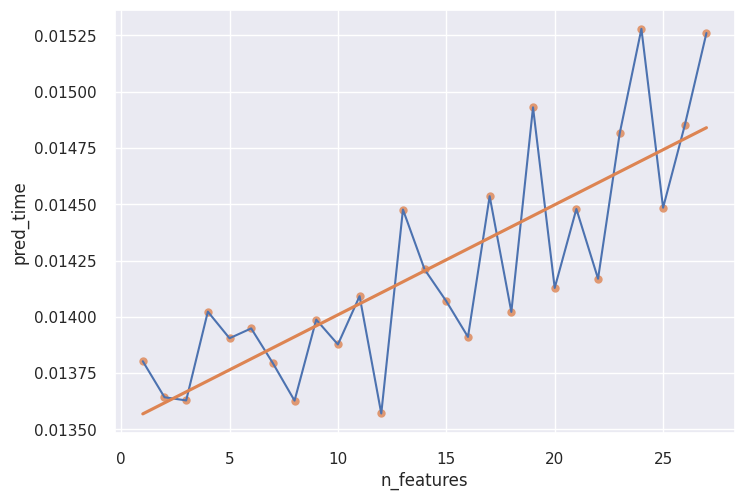

In [40]:
def print_plot():
    data = zero_day_feature_reduction_scores.groupby('n_features')[['pred_time','n_features']].mean().query('n_features < 79')
    sns.set_theme()
    sns.lineplot(data=data, x=data.index, y='pred_time')
    sns.regplot(data=data, x="n_features", y="pred_time", ci=None)  # ci=None removes confidence intervals

print_plot()

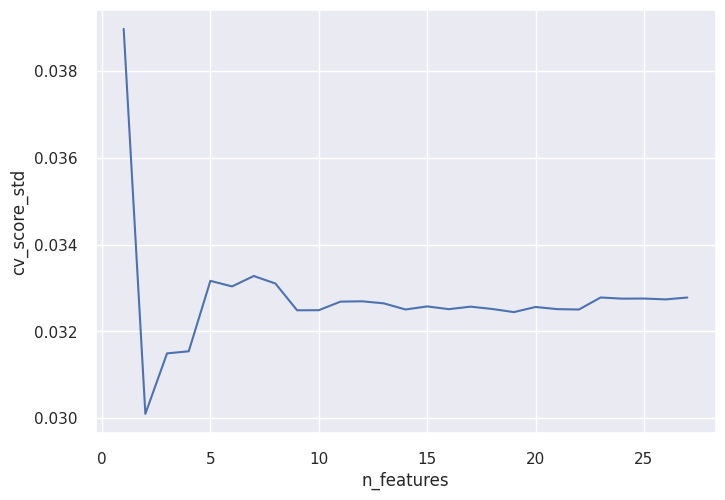

In [41]:
def print_plot():
    data = zero_day_feature_reduction_scores.groupby('n_features')[['cv_score_std','n_features']].mean().query('n_features < 79')
    sns.set_theme()
    sns.lineplot(data=data, x=data.index, y='cv_score_std')

print_plot()

In [42]:
zero_day_feature_reduction_scores.groupby('n_features')[['attack_f1','attack_recall','attack_precision','cv_score_avg','cv_score_std','fit_time','pred_time', 'detected']].mean().sort_values(['attack_recall', 'attack_precision'], ascending=False)

,attack_f1,attack_recall,attack_precision,cv_score_avg,cv_score_std,fit_time,pred_time,detected
n_features,,,,,,,,
5,0.381884,0.356969,0.418593,0.949899,0.033163,0.027123,0.013905,0.50
6,0.381642,0.356740,0.418349,0.950023,0.033034,0.030130,0.013949,0.50
7,0.346061,0.300320,0.409210,0.949749,0.033275,0.040847,0.013794,0.50
9,0.298921,0.242223,0.393998,0.951114,0.032484,0.038148,0.013987,0.75
8,0.298891,0.242223,0.393910,0.950429,0.033101,0.037690,0.013627,0.75
4,0.293785,0.238411,0.392674,0.950703,0.031539,0.030370,0.014023,0.50
2,0.288923,0.237954,0.375665,0.937677,0.030097,0.027432,0.013643,0.50
3,0.293055,0.237725,0.392191,0.951020,0.031491,0.029866,0.013628,0.50
11,0.279420,0.229872,0.377550,0.950729,0.032684,0.048510,0.014092,0.50


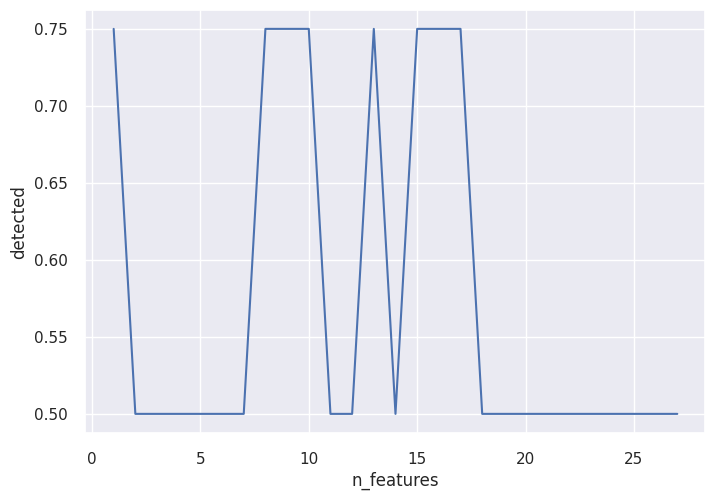

In [43]:
def print_plot():
    data = zero_day_feature_reduction_scores.groupby('n_features')[['detected','n_features']].mean().query('n_features < 79')
    sns.set_theme()
    sns.lineplot(data=data, x=data.index, y='detected')

print_plot()

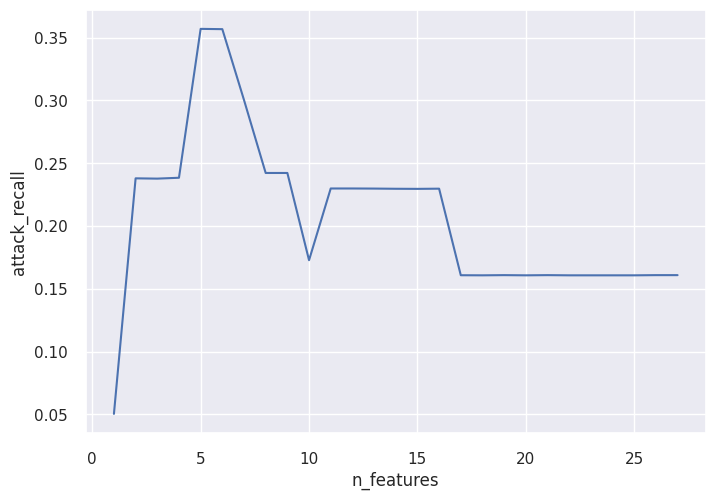

In [44]:
def print_plot():
    data = zero_day_feature_reduction_scores.groupby('n_features')[['attack_recall','n_features']].mean().query('n_features < 79')
    sns.set_theme()
    sns.lineplot(data=data, x=data.index, y='attack_recall')

print_plot()

In [45]:
zero_day_feature_reduction_scores.groupby('n_features')[['attack_f1','attack_recall','attack_precision','cv_score_avg','cv_score_std','fit_time','pred_time', 'detected']].mean().sort_values('attack_f1', ascending=False)

,attack_f1,attack_recall,attack_precision,cv_score_avg,cv_score_std,fit_time,pred_time,detected
n_features,,,,,,,,
5,0.381884,0.356969,0.418593,0.949899,0.033163,0.027123,0.013905,0.50
6,0.381642,0.356740,0.418349,0.950023,0.033034,0.030130,0.013949,0.50
7,0.346061,0.300320,0.409210,0.949749,0.033275,0.040847,0.013794,0.50
9,0.298921,0.242223,0.393998,0.951114,0.032484,0.038148,0.013987,0.75
8,0.298891,0.242223,0.393910,0.950429,0.033101,0.037690,0.013627,0.75
4,0.293785,0.238411,0.392674,0.950703,0.031539,0.030370,0.014023,0.50
3,0.293055,0.237725,0.392191,0.951020,0.031491,0.029866,0.013628,0.50
2,0.288923,0.237954,0.375665,0.937677,0.030097,0.027432,0.013643,0.50
13,0.279447,0.229796,0.378157,0.950465,0.032644,0.054523,0.014477,0.75


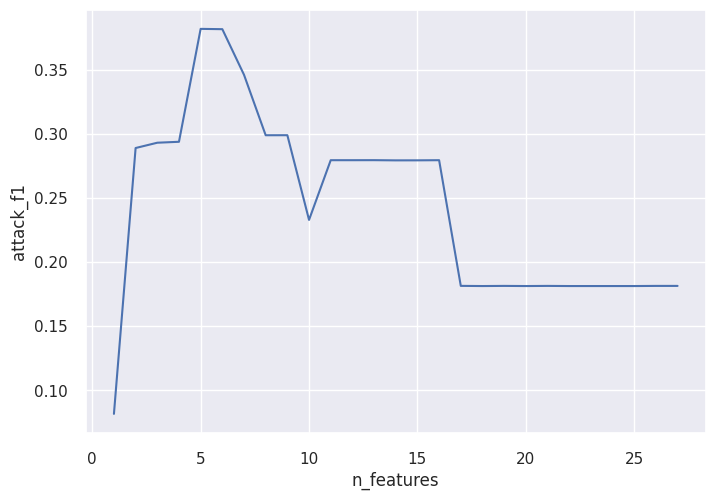

In [46]:
def print_plot():
    data = zero_day_feature_reduction_scores.groupby('n_features')[['attack_f1','n_features']].mean().query('n_features < 79')
    sns.set_theme()
    sns.lineplot(data=data, x=data.index, y='attack_f1')

print_plot()

In [47]:
zero_day_feature_reduction_scores.query('n_features == 5')

,attack_f1,attack_recall,attack_precision,cv_score_avg,cv_score_std,n_features,attack_name,fit_time,pred_time,detected
23,0.000000,0.000000,0.000000,0.946619,0.045552,5,XMRIGCC CryptoMiner,0.026991,0.013877,0
51,0.000000,0.000000,0.000000,0.980310,0.002635,5,Probing,0.027262,0.014146,0
79,0.868945,0.872522,0.865396,0.938322,0.042812,5,Bruteforce,0.027115,0.014117,1
107,0.658590,0.555352,0.808974,0.934343,0.041653,5,Bruteforce-XML,0.027122,0.013479,1


In [48]:
zero_day_feature_reduction_scores.query('n_features == 79')

,attack_f1,attack_recall,attack_precision,cv_score_avg,cv_score_std,n_features,attack_name,fit_time,pred_time,detected
0,0.000000,0.000000,0.000000,0.945227,0.047287,79,XMRIGCC CryptoMiner,0.306110,0.017001,0
28,0.000000,0.000000,0.000000,0.979619,0.002396,79,Probing,0.286125,0.017606,0
56,0.086888,0.050625,0.306273,0.945214,0.038224,79,Bruteforce,0.215656,0.015179,1
84,0.000000,0.000000,0.000000,0.942394,0.037937,79,Bruteforce-XML,0.266787,0.015212,0
